In [1]:
import cv2
import pandas as pd
import numpy as np
import time
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt
import os
import glob
%matplotlib inline

from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
zip_file = zipfile.ZipFile(file = "/content/drive/MyDrive/Deep_Learning/Face_Recognation/Material.zip",mode = "r")
zip_file.extractall("./")
zip_file.close()

In [3]:
zip_file = zipfile.ZipFile(file = "/content/Material/fer2013.zip",mode = "r")
zip_file.extractall("./")
zip_file.close()

In [67]:
classes = ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'] 

total = []
emotions = []
name_img = []
name_emotion = []

max_photo = 3000

for i,classe in enumerate(classes):
    imgs_training = glob.glob("/content/fer2013/train/"+classe+"/*")
    a = 0
    
    for img in imgs_training:
        total.append(img)
        name_img.append(str(img.split("/")[-1]))
        emotions.append(i)
        name_emotion.append(classe)
        a = a+1
        if a >=max_photo:
            break
    
    print("Number of Images "+ classe + " = "+str(len(imgs_training)))

dataset = pd.DataFrame()
dataset["img"] = name_img
dataset["emotion"] = emotions
dataset["class"] = name_emotion

Number of Images Angry = 3995
Number of Images Fear = 4097
Number of Images Happy = 7215
Number of Images Sad = 4830
Number of Images Surprise = 3171
Number of Images Neutral = 4965


In [68]:
print("Shape : ", dataset.shape)
dataset.head()

Shape :  (18000, 3)


,img,emotion,class
0,3865.jpg,0,Angry
1,296.jpg,0,Angry
2,764.jpg,0,Angry
3,687.jpg,0,Angry
4,2044.jpg,0,Angry


In [69]:
# Example
total[0]

'/content/fer2013/train/Angry/3865.jpg'

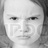

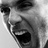

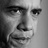

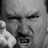

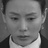

200 photo upload [+0.03s]
400 photo upload [+0.02s]
600 photo upload [+0.01s]
800 photo upload [+0.01s]
1000 photo upload [+0.01s]
1200 photo upload [+0.01s]
1400 photo upload [+0.01s]
1600 photo upload [+0.01s]
1800 photo upload [+0.01s]
2000 photo upload [+0.01s]
2200 photo upload [+0.01s]
2400 photo upload [+0.01s]
2600 photo upload [+0.01s]
2800 photo upload [+0.01s]
3000 photo upload [+0.01s]
3200 photo upload [+0.01s]
3400 photo upload [+0.01s]
3600 photo upload [+0.01s]
3800 photo upload [+0.01s]
4000 photo upload [+0.01s]
4200 photo upload [+0.01s]
4400 photo upload [+0.01s]
4600 photo upload [+0.01s]
4800 photo upload [+0.01s]
5000 photo upload [+0.01s]
5200 photo upload [+0.01s]
5400 photo upload [+0.01s]
5600 photo upload [+0.01s]
5800 photo upload [+0.01s]
6000 photo upload [+0.01s]
6200 photo upload [+0.01s]
6400 photo upload [+0.01s]
6600 photo upload [+0.02s]
6800 photo upload [+0.01s]
7000 photo upload [+0.01s]
7200 photo upload [+0.01s]
7400 photo upload [+0.01s]
7600 

In [70]:
from PIL import Image
import time

width,height = 48,48

faces = []
samples = 0
t = time.time()
t_total = time.time()

for face in total:
    # img = Image.open(face).convert("L")
    img = cv2.imread(face,0)
    img = np.asarray(img).reshape(width,height)
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(width,height))

    samples+=1
    faces.append(img)

    if (samples % 200 ==0):
        print(str(samples) + " photo upload [+" + str(round(time.time()- t,2)) + "s]")
        t=time.time()

    if samples <= 5:
        cv2_imshow(img)

print("Total Time : ",str(time.time() - t_total))

In [71]:
dataset.head()

,img,emotion,class
0,3865.jpg,0,Angry
1,296.jpg,0,Angry
2,764.jpg,0,Angry
3,687.jpg,0,Angry
4,2044.jpg,0,Angry


In [72]:
dataset.tail()

,img,emotion,class
17995,4000.jpg,5,Neutral
17996,3112.jpg,5,Neutral
17997,27.jpg,5,Neutral
17998,2241.jpg,5,Neutral
17999,279.jpg,5,Neutral


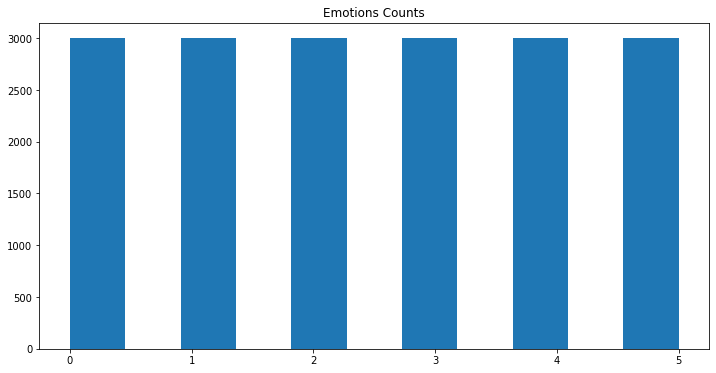

In [73]:
plt.figure(figsize = (12,6))
plt.hist(dataset["emotion"],bins = 11)
plt.title("Emotions Counts")
plt.show()

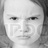

In [74]:
cv2_imshow(faces[0])

In [75]:
faces = np.asarray(faces)
faces = np.expand_dims(faces,-1)

def normalizer(x):
    x = x.astype("float32")
    x = x / 255.0
    return x

faces = normalizer(faces)

In [76]:
print("Max : ",faces.max())
print("Min : ",faces.min())

Max :  1.0
Min :  0.0


In [77]:
print("Number of total image dataset :",str(len(faces)))

Number of total image dataset : 18000


In [78]:
labels = pd.get_dummies(dataset["emotion"]).values
labels[:2]

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]], dtype=uint8)

In [79]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

In [80]:
X_train,X_test,y_train,y_test = train_test_split(faces,labels,test_size = 0.1, random_state = 42)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.1, random_state = 41)

print('Number of images in the training set: ', len(X_train))
print('Number of images in the test set: ', len(X_test))
print('Number of images in the validation set: ', len(X_val))

Number of images in the training set:  14580
Number of images in the test set:  1800
Number of images in the validation set:  1620


In [81]:
np.save("mod_xtest_aug",X_test)
np.save("mod_ytest_aug",y_test)

In [82]:
num_features = 32
num_classes = 6
width, height = 48, 48
batch_size = 64
epochs = 100

model = Sequential()

model.add(Conv2D(filters = num_features, kernel_size = (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (width, height, 1)))
model.add(Activation("elu"))
model.add(BatchNormalization())
model.add(Conv2D(filters = num_features, kernel_size = (3, 3), padding = 'same', kernel_initializer="he_normal"))
model.add(Activation("elu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.2))

model.add(Conv2D(filters = 2*num_features, kernel_size = (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 2*num_features, kernel_size = (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate = 0.2))

model.add(Conv2D(filters = 2*2*num_features, kernel_size = (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 2*2*num_features, kernel_size = (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate = 0.2))

model.add(Conv2D(filters = 2*2*2*num_features, kernel_size = (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 2*2*2*num_features, kernel_size = (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate = 0.2))

model.add(Flatten())
model.add(Dense(2*num_features, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2*num_features, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(units = num_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 activation_33 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_30 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 activation_34 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_31 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                     

In [83]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
                    rotation_range = 10,
                    shear_range = 0.1,
                    zoom_range = 0.1,
                    width_shift_range = 0.1,
                    height_shift_range = 0.1,
                    horizontal_flip = True,
                    fill_mode = "nearest")

datagen.flow(X_train,y_train)

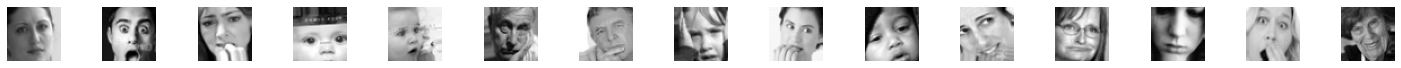

In [84]:
batches = datagen.flow(X_train,y_train,batch_size = 15)
X_batch,y_batch = next(batches)

fig, ax = plt.subplots(1,15, figsize = (20,5))
fig.tight_layout()

for i in range(15):
    ax[i].imshow(X_batch[i].reshape((48,48)),cmap = "gray")
    ax[i].axis("off")

plt.show()

In [85]:
model.compile(loss = categorical_crossentropy,
              optimizer= Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7),
              metrics = ["accuracy"])

file_model_json = "model_02_expressions_aug.json"
file_model = "model_02_expressions_aug.h5"

lr_reducer = ReduceLROnPlateau(monitor = "val_loss", factor = 0.9, patience = 3, verbose= 1)
early_stopper = EarlyStopping(monitor = "val_loss", min_delta = 0, patience = 8, verbose = 1, mode = "auto")
checkpointer = ModelCheckpoint(file_model,monitor = "val_loss",verbose = 1, save_best_only=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [86]:
model_json = model.to_json()
with open(file_model_json,"w") as json_file:
    json_file.write(model_json)

In [87]:
np.array(X_train).shape

(14580, 48, 48, 1)

In [88]:
#history = model.fit(np.array(X_train),np.array(y_train),
#                    batch_size = batch_size,
#                    epochs = epochs ,
#                    verbose = 1,
#                    validation_data = (np.array(X_val),np.array(y_val)),
#                    shuffle = True,
#                    callbacks = [lr_reducer,early_stopper,checkpointer])

In [89]:
history_generator = model.fit_generator(
                    datagen.flow(X_train,y_train,batch_size = batch_size),
                    epochs = epochs ,
                    verbose = 1,
                    validation_data = (X_val,y_val),
                    validation_steps = len(X_val) // batch_size,
                    steps_per_epoch = len(X_train) // batch_size,
                    callbacks = [lr_reducer,early_stopper,checkpointer]
)

Epoch 1/70


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


227/227 [==============================] - ETA: 0s - loss: 2.3224 - accuracy: 0.1969
Epoch 1: val_loss improved from inf to 1.72142, saving model to model_02_expressions_aug.h5
227/227 [==============================] - 10s 36ms/step - loss: 2.3224 - accuracy: 0.1969 - val_loss: 1.7214 - val_accuracy: 0.2722 - lr: 0.0010
Epoch 2/70
227/227 [==============================] - ETA: 0s - loss: 1.9026 - accuracy: 0.2308
Epoch 2: val_loss improved from 1.72142 to 1.62334, saving model to model_02_expressions_aug.h5
227/227 [==============================] - 8s 34ms/step - loss: 1.9026 - accuracy: 0.2308 - val_loss: 1.6233 - val_accuracy: 0.3358 - lr: 0.0010
Epoch 3/70
227/227 [==============================] - ETA: 0s - loss: 1.7182 - accuracy: 0.2873
Epoch 3: val_loss did not improve from 1.62334
227/227 [==============================] - 7s 32ms/step - loss: 1.7182 - accuracy: 0.2873 - val_loss: 1.6589 - val_accuracy: 0.3191 - lr: 0.0010
Epoch 4/70
227/227 [==============================] 

In [93]:
scores = model.evaluate(np.array(X_test),np.array(y_test),batch_size = batch_size)
print("Accuracy : ", scores[1] )
print("Loss : ", scores[0])

29/29 [==============================] - 0s 10ms/step - loss: 1.0958 - accuracy: 0.6267
Accuracy :  0.6266666650772095
Loss :  1.0957711935043335


In [94]:
def history_graph(history):

    fig,ax = plt.subplots(1,2,figsize =(15,6))
    ax[0].plot(range(1,len(history.history["accuracy"]) + 1), history.history["accuracy"],"r")
    ax[0].plot(range(1,len(history.history["val_accuracy"]) + 1), history.history["val_accuracy"],"b")
    ax[0].set_title("Accuracy Model")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_xticks(np.arange(1,len(history.history["accuracy"]) + 1),
                     len(history.history["accuracy"]) / 10)
    
    ax[0].legend(["Training Accuracy", "Validation Accuracy"])
    
    ax[1].plot(range(1,len(history.history["loss"]) + 1), history.history["loss"],"r")
    ax[1].plot(range(1,len(history.history["val_loss"]) + 1), history.history["val_loss"],"b")
    ax[1].set_title("Loss Model")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_xticks(np.arange(1,len(history.history["loss"]) + 1),
                     len(history.history["loss"]) / 10)
    
    ax[1].legend(["Training Loss", "Validation Loss"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


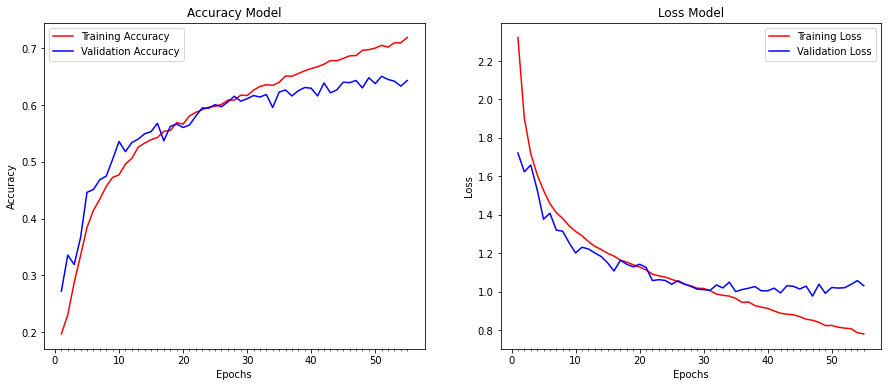

In [95]:
history_graph(history_generator)

In [108]:
y = np.load("/content/mod_ytest_aug.npy")
x = np.load("/content/mod_xtest_aug.npy")
model.predict(x[0].reshape(1,48,48,1))

array([[0.01485566, 0.07051528, 0.01900086, 0.00294757, 0.8869808 ,
        0.00569995]], dtype=float32)

In [111]:
true_y = []
pred_y = []
x = np.load("/content/mod_xtest_aug.npy")
y = np.load("/content/mod_ytest_aug.npy")

json_file = open(file_model_json,"r")
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(file_model)

y_pred = loaded_model.predict(x)
yp = y_pred.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yp[i])
    yyt = max(yt[i])
    pred_y.append(yp[i].index(yy))
    true_y.append(yt[i].index(yyt))
    if (yp[i].index(yy) == yt[i].index(yyt)):
        count+=1

acc = (count/len(y))*100
np.save("truey_aug",true_y)
np.save("predy_aug",pred_y)
print("Accuracy Test : " + str(round(acc,2)) + "%")

Accuracy Test : 61.83%


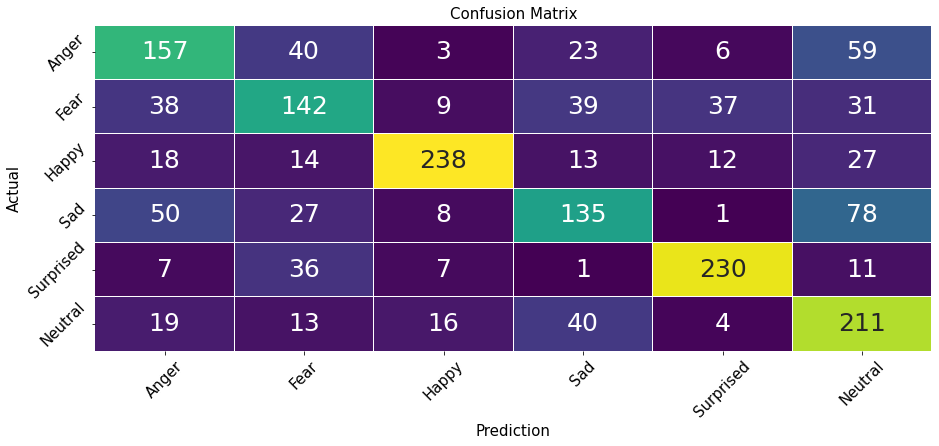

In [114]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = np.load("/content/truey_aug.npy")
y_pred = np.load("/content/predy_aug.npy")

expressions = ['Anger', 'Fear', 'Happy', 'Sad', 'Surprised', 'Neutral']

def confusion_matrix_graph(y_true,y_pred,label):
    cm = confusion_matrix(y_true,y_pred)
    size = 15

    plt.figure(figsize = (15,6))
    sns.heatmap(cm,annot=True,fmt = "d",cmap = "viridis", cbar = False, xticklabels=label,yticklabels = label,
                linecolor="white",linewidths=.2,annot_kws = {"size":25,})
    

    plt.title("Confusion Matrix",fontsize = size)
    plt.ylabel("Actual",fontsize = size)
    plt.xlabel("Prediction",fontsize = size)
    plt.yticks(rotation = 45,fontsize = size)
    plt.xticks(rotation = 45,fontsize = size)
    plt.show()

confusion_matrix_graph(y_true,y_pred,expressions)

# Testing

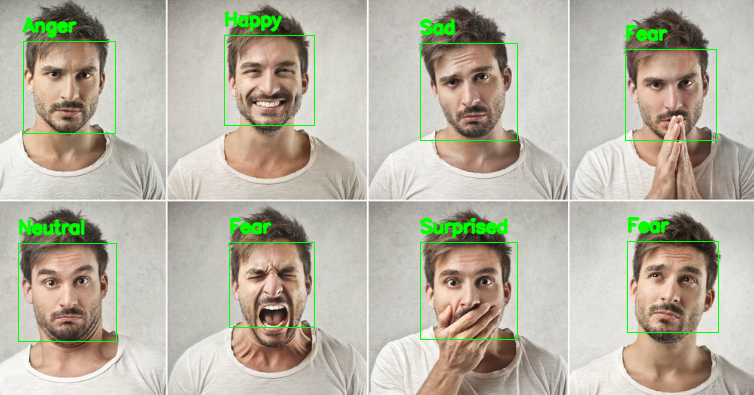

In [116]:
face_cascade = cv2.CascadeClassifier("/content/Material/haarcascade_frontalface_default.xml")
expressions = ['Anger', 'Fear', 'Happy', 'Sad', 'Surprised', 'Neutral']

img = cv2.imread("/content/Material/testes/teste02.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray,1.1,3)

for x,y,w,h in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)
    roi_gray = gray[y:y+h,x:x+w]
    roi_gray = roi_gray.astype("float") / 255.0
    resize = cv2.resize(roi_gray,(48,48))
    cropped_img = np.expand_dims(np.expand_dims(resize,-1), 0)
    prediction = loaded_model.predict(cropped_img)[0]

    label = expressions[int(np.argmax(prediction))]

    cv2.putText(img,label,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,255,0),2,cv2.LINE_AA)

cv2_imshow(img)